<a href="https://colab.research.google.com/github/ujjawalsingh10/Pytorch-Deep-Learning/blob/main/06_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

print(torch.__version__)

2.5.1+cu124


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1456), reused 1399 (delta 1399), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 31.31 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [3]:
## device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get Data

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")


Did not find data/pizza_steak_sushi, downloading it...
Unzipping pizza, steak, sushi data...


In [5]:
## setup directory path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [6]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and Dataloaders

### 2.1 Creating a transform for torchvision.models (manual creation)

In [7]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), ## resize the iamge
    transforms.ToTensor(), ## get the images into [0,1] range
    normalize # make sure the images have the same distribution as Imagenet (where the model has been trained)
])

In [8]:
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [9]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32)


In [10]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7af6df4e5cd0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating transform for torchvision.models (auto creation)

In [11]:
# get a set of pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # deafault = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
# get the transforms used to create pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
# Create Dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                   test_dir = test_dir,
                                                                   transform = auto_transforms,
                                                                   batch_size = 32)

## 3. Getting a pretrained model
1. Pytorch domain libraries
2. Libraries like `timm` (torch image models)
3. Huggingface
4. paperswithcode

### 3.1 which pretrained model to use

In [14]:
## old method
# model = torchvision.models.efficientnet_b0(pretrained=True)

# new method
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # gives best available weights
model = torchvision.models.efficientnet_b0(weights = weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 112MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [16]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with torchinfo.summary()

In [18]:
# print a summary with torchinfo
from torchinfo import summary
summary(model = model,
        input_size = (1, 3, 244, 244),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 244, 244]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 244, 244]     [1, 1280, 8, 8]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 244, 244]     [1, 32, 122, 122]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 244, 244]     [1, 32, 122, 122]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 122, 122]    [1, 32, 122, 122]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 122, 122]    [1, 32, 122, 122]    --                   --
│    └─Sequential (1)                                        [1, 32, 122, 122]    [1, 16, 122,

### 3.4 Freezing the base model and changing the output layer to suit our needs

In [19]:
# Freeze all the base layers in EffnetB0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [20]:
# update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features = len(class_names))
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [21]:
summary(model = model,
        input_size = (1, 3, 244, 244),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 244, 244]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 244, 244]     [1, 1280, 8, 8]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 244, 244]     [1, 32, 122, 122]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 244, 244]     [1, 32, 122, 122]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 122, 122]    [1, 32, 122, 122]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 122, 122]    [1, 32, 122, 122]    --                   --
│    └─Sequential (1)                                        [1, 32, 122, 122]    [1, 1

## 4. Train Model

In [22]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# import train function
from going_modular.going_modular import engine

# set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# setup training and save the model
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

# end timer
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 17.915 seconds


## 5. Evaluate model by plotting loss curves

In [24]:
results

{'train_loss': [1.0924270078539848,
  0.8716965168714523,
  0.7647949680685997,
  0.7108824849128723,
  0.6254763826727867],
 'train_acc': [0.3984375, 0.77734375, 0.79296875, 0.75390625, 0.78515625],
 'test_loss': [0.9132681687672933,
  0.7911976178487142,
  0.7463406721750895,
  0.6373109420140585,
  0.6261005997657776],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061]}

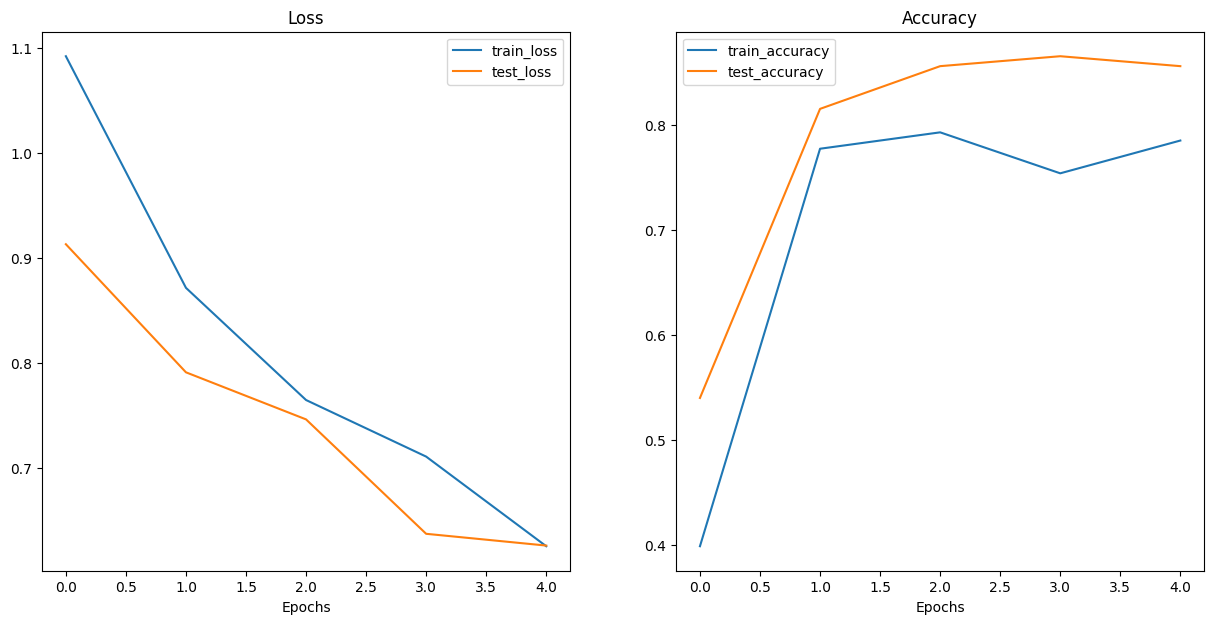

In [29]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] couldn't find the file. Downloading...")
  with open('helper_functions.py', 'wb') as f:
    import requests
    response = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    f.write(response.content)
    print('Downloaded !!')
from helper_functions import plot_loss_curves
plot_loss_curves(results)

## 6. Make predictions on images from the test set

In [30]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

# Take in the trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224,224),
                        transform: torchvision.transforms = None,
                        device : torch.device = device):

  # Open the image
  img = Image.open(image_path)

  # create a transform if one doesn't exist
  if transform:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

  ### predict on image ###
  # make sure the model is on target device
  model.to(device)

  # Turn on inf and eval mode
  model.eval()
  with torch.inference_mode():
    # transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim = 0)

    # make a prediction
    target_image_pred = model(transformed_image.to(device))

  # convert logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

  # convert pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

  # plot the image and predicted class
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}")
  plt.axis('off')

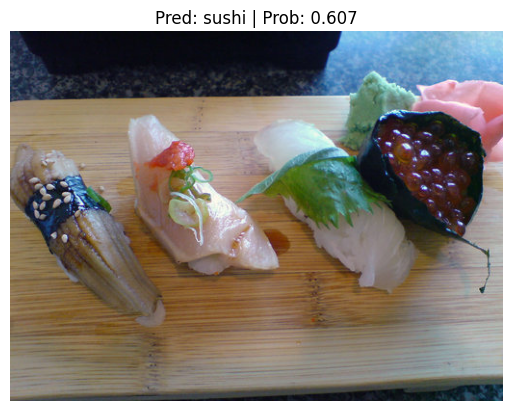

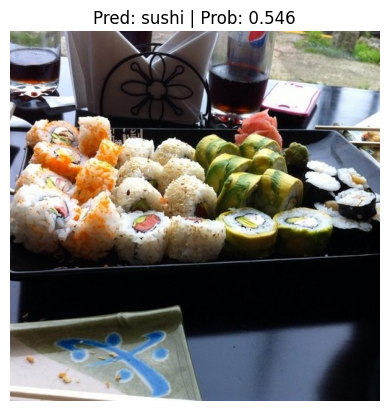

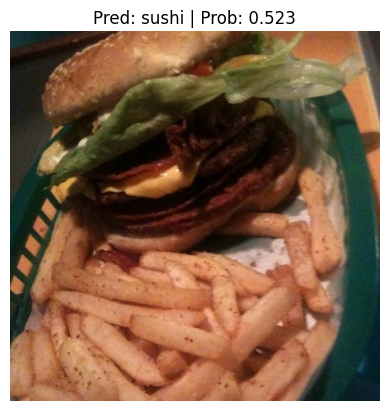

In [42]:
# get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(test_image_path_list, k = num_images_to_plot)

# make prediction on and plot images
for image_path in test_image_path_sample:
  pred_and_plot_image(model = model,
                      image_path = image_path,
                      class_names = class_names,
                      image_size = (224,224))

### 6.1 Mkaing prediction in a custom image

In [44]:
import requests

custom_image_path = data_path / 'custom_image.jpeg'

if not custom_image_path.is_file():
  print(f"{custom_image_path} doesn't exist, downloading...")
  with open(custom_image_path, 'wb') as f:
    response = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg')
    f.write(response.content)
    print('Downloaded !!')
else:
  print(f"{custom_image_path} already exists skipping download")

data/custom_image.jpeg doesn't exist, downloading...
Downloaded !!


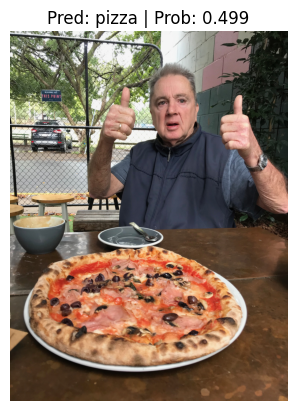

In [45]:
# predict on custom image
pred_and_plot_image(model = model,
                    image_path = custom_image_path,
                    class_names = class_names,
                    )